### Alberto Bermejo DÍez
### 000444772
### Travail numérique de PHYS-F302


In [294]:
import numpy
import sympy
from matplotlib import pyplot
from math import pi
%matplotlib inline
from laplace_helper import plot_3D, L2_rel_error
from cg_helper import poisson_2d, p_analytical

## Discretization - Coding assignment

## Find a second-order, central finite difference discretization of the biharmonic equation.
## Implement the boundary conditions using forward or backward, second order accurate finite differences (use only interior boundary nodes).
## Solve the biharmonic equation using the conjugate gradient method.
## What is the value of the stream function at location (x,y): (0.6,0.2), (0.6,0.4), (0.6,0.6), (0.6,0.8)?

### Premièrement, je vais essayer de discrétiser l'équation biharmonique, ensuite, implementer les conditions aux bords "backward" et, dernièrement, appliquer la méthode du gradient conjugué pour resoudre l'équation biharmonique.

In [295]:
nx = 41
ny = 41
l = 1.
h = 1.
dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-8
p = numpy.zeros((nx,ny))
p_i = p

x  = numpy.linspace(0,l,nx)
y  = numpy.linspace(0,h,ny)
X,Y = numpy.meshgrid(x,y)

## La discrétisation à 1D de l'équation biharmonique est la suivante:

## $$  [\nabla^4\psi]_i = \frac{1}{\Delta^4} (\psi_{i-2} -4\psi_{i-1} + 6\psi_i -4\psi_{i+1} + \psi_{i+2}) $$

## Les conditions aux bords  sont les suivantes:

### $$   \psi_{N-5} -4\psi_{N-4} + 6\psi_{N-3} -\frac{15}{4}\psi_{N-2}  = \frac{\Delta}{2}$$
### $$   \psi_{N-4} -4\psi_{N-3} + 5\psi_{N-2}   = -2\Delta$$
### $$   -2\psi_{N-2} +\frac{1}{2}\psi_{N-1}   = \Delta$$

## En représentation matricielle, l'opérateur de l'équation biharmonique discrétisé A, avec les conditions aux bords implementés, est exprimé:

In [296]:
def BH_operator(nx, ny, dx):
    M = numpy.diag((6.0) * numpy.ones(nx))
    U = numpy.diag(-4.0 * numpy.ones(nx - 1), k = 1)
    L = numpy.diag(-4.0 * numpy.ones(nx - 1), k = -1)
    I = numpy.diag(1.0 * numpy.ones(nx - 2), k = 2)
    J = numpy.diag(1.0 * numpy.ones(nx - 2), k = -2)
    A = M + U + L  + I + J
    return A

In [297]:
B=BH_operator(nx-2, ny-2, dx)
B[0,0]=5
B[-1,-1]=5
B[1,0]=-15/4
B[-2,-1]=-15/4
print(B)
print(B[2])

[[ 5.   -4.    1.   ...  0.    0.    0.  ]
 [-3.75  6.   -4.   ...  0.    0.    0.  ]
 [ 1.   -4.    6.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  6.   -4.    1.  ]
 [ 0.    0.    0.   ... -4.    6.   -3.75]
 [ 0.    0.    0.   ...  1.   -4.    5.  ]]
[ 1. -4.  6. -4.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]


In [298]:
A=BH_operator(nx, ny, dx)
A[0,0]=0
A[0,1]=0
A[0,2]=0
A[1,0]=0
A[2,0]=0
A[0,-2]=-2
A[0,-1]=0.5
A[1,1]=5
A[-1,-1]=5
A[2,1]=-15/4
A[-3,-2]=-15/4
A[-3,-1]=0
A[-2,-1]=0
A[-1,-3]=0
A[-1,-1]=0.5
A[-1,-2]=-2
print(A)

[[ 0.    0.    0.   ...  0.   -2.    0.5 ]
 [ 0.    5.   -4.   ...  0.    0.    0.  ]
 [ 0.   -3.75  6.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  6.   -3.75  0.  ]
 [ 0.    0.    0.   ... -4.    6.    0.  ]
 [ 0.    0.    0.   ...  0.   -2.    0.5 ]]


In [299]:
b = numpy.zeros(ny)
b[-3] = 0.5 * dy
b[-2] = -2 * dy
b[-1] = dy
print(b)

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.0125 -0.05    0.025 ]


## L'équation biharmonique discrétisée correspond au système linéaire suivant:   

## $$A\psi = b$$

In [300]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

In [301]:
def conjugate_gradient_2d(p, b, dx, dy, l2_target):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = p.shape
    r  = numpy.zeros((ny,nx)) # residual
    Ad  = numpy.zeros((ny,nx)) # to store result of matrix multiplication 
    
    l2_norm = 1
    iterations = 0
    l2_conv = []
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    
    
    
    r[2:-1,2:-1] = b[2:-1] + (6*p[2:-1,2:-1] - \
        4*p[1:-2,2:-1] - 4*p[2:-1,1:-2] + p[3:,2:-1] + p[:-3,2:-1])/dx**4
    d = r.copy()
    d[1:-2, -2] = -2 * dy/dx**4
    d[1:-2, -3] = 0.5 * dy/dx**4
    print(d[1])
    rho = numpy.sum(r*r)
    Ad[2:-1,2:-1] = (6*p[2:-1,2:-1] - \
        4*p[1:-2,2:-1] - 4*p[2:-1,1:-2] + p[3:,2:-1] + p[:-3,2:-1])/dx**4
    Ad[1:-1,-5] = 0.5 * dy /dx**4
    Ad[1:-1,-4] = -4 * dy /dx**4
    Ad[1:-1,-3] = 10.5 * dy /dx**4
    Ad[1:-1,-2] = 12 * dy /dx**4
    print(Ad[1])
    sigma = numpy.sum(d*Ad)
    
    # Iterations
    while l2_norm > l2_target:

        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma

        p = pk + alpha*dk
        r = rk- alpha*Ad
        
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        Ad[2:-1,2:-1] =(6*p[2:-1,2:-1] - \
        4*p[1:-2,2:-1] - 4*p[2:-1,1:-2] + p[3:,2:-1] + p[:-3,2:-1])/dx**4
        sigma = numpy.sum(d*Ad)
        
        # BCs are automatically enforced
        
        l2_norm = L1norm(pk,p)
        iterations += 1
        l2_conv.append(l2_norm)
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p, l2_conv     


In [302]:
p, l2_conv = conjugate_gradient_2d(p_i.copy(), b, dx, dy, 1e-6)

[      0.       0.       0.       0.       0.       0.       0.       0.
       0.       0.       0.       0.       0.       0.       0.       0.
       0.       0.       0.       0.       0.       0.       0.       0.
       0.       0.       0.       0.       0.       0.       0.       0.
       0.       0.       0.       0.       0.       0.   32000. -128000.
       0.]
[      0.       0.       0.       0.       0.       0.       0.       0.
       0.       0.       0.       0.       0.       0.       0.       0.
       0.       0.       0.       0.       0.       0.       0.       0.
       0.       0.       0.       0.       0.       0.       0.       0.
       0.       0.       0.       0.   32000. -256000.  672000.  768000.
       0.]
Number of CG iterations: 1


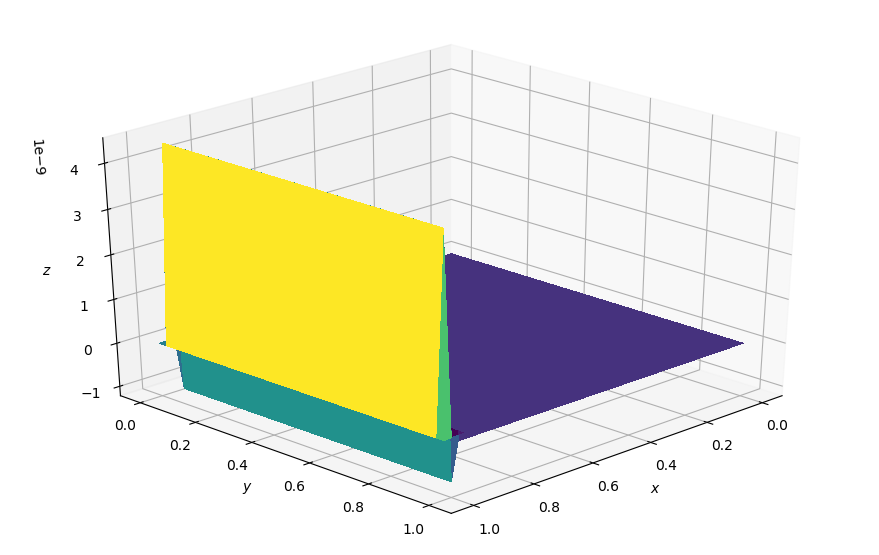

In [303]:
plot_3D(x,y,p)

Text(0,0.5,'$y$')

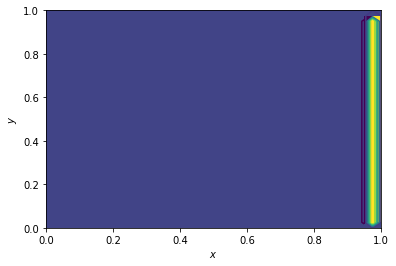

In [304]:
mesh = pyplot.pcolormesh(x, y, p)

cs = pyplot.contour(x, y, p)

pyplot.xlabel('$x$')
pyplot.ylabel('$y$')